In [17]:
import os
import shutil
import itertools
import pathlib
from PIL import Image

#Data handling
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report , ConfusionMatrixDisplay

#Deep learnings tools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Conv2D , MaxPooling2D , Flatten , Activation , Dropout , BatchNormalization
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers
from keras.applications import Xception,VGG16,ResNet50
#warnings
import warnings
warnings.filterwarnings('ignore')

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
import zipfile
import os

# Path to the ZIP file
zip_file_path = '/content/drive/MyDrive/scence classification zipped/archive.zip'

# Directory where you want to extract the contents
extract_dir = 'extracted_files'

# Create the extraction directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

##Data preparation

In [21]:
train_data = '/content/extracted_files/seg_train/seg_train'
test_data = '/content/extracted_files/seg_test/seg_test'

filepath= []
label =[]

folds = os.listdir(train_data)

for fold in folds:
    f_path = os.path.join(train_data , fold)
    imgs = os.listdir(f_path)

    for img in imgs:
        img_path = os.path.join(f_path , img)
        filepath.append(img_path)
        label.append(fold)

#Concat data paths with labels
fseries = pd.Series(filepath , name= 'filepaths')
lseries = pd.Series(label , name = 'labels')
train_df = pd.concat([fseries , lseries] , axis = 1)

In [22]:
folds = os.listdir(test_data)

for fold in folds:
    f_path = os.path.join(test_data , fold)
    imgs = os.listdir(f_path)

    for img in imgs:
        img_path = os.path.join(f_path , img)
        filepath.append(img_path)
        label.append(fold)

#Concat data paths with labels
fseries = pd.Series(filepath , name= 'filepaths')
lseries = pd.Series(label , name = 'labels')
ts_df = pd.concat([fseries , lseries] , axis = 1)

In [23]:
train_df

filepaths  labels
0      /content/extracted_files/seg_train/seg_train/s...     sea
1      /content/extracted_files/seg_train/seg_train/s...     sea
2      /content/extracted_files/seg_train/seg_train/s...     sea
3      /content/extracted_files/seg_train/seg_train/s...     sea
4      /content/extracted_files/seg_train/seg_train/s...     sea
...                                                  ...     ...
14029  /content/extracted_files/seg_train/seg_train/s...  street
14030  /content/extracted_files/seg_train/seg_train/s...  street
14031  /content/extracted_files/seg_train/seg_train/s...  street
14032  /content/extracted_files/seg_train/seg_train/s...  street
14033  /content/extracted_files/seg_train/seg_train/s...  street

[14034 rows x 2 columns]

In [24]:
ts_df

filepaths  labels
0      /content/extracted_files/seg_train/seg_train/s...     sea
1      /content/extracted_files/seg_train/seg_train/s...     sea
2      /content/extracted_files/seg_train/seg_train/s...     sea
3      /content/extracted_files/seg_train/seg_train/s...     sea
4      /content/extracted_files/seg_train/seg_train/s...     sea
...                                                  ...     ...
17029  /content/extracted_files/seg_test/seg_test/str...  street
17030  /content/extracted_files/seg_test/seg_test/str...  street
17031  /content/extracted_files/seg_test/seg_test/str...  street
17032  /content/extracted_files/seg_test/seg_test/str...  street
17033  /content/extracted_files/seg_test/seg_test/str...  street

[17034 rows x 2 columns]

##Data splitting

In [25]:
valid , test = train_test_split(ts_df , test_size= 0.5 , shuffle = True , random_state = 42)

In [26]:
print(f"Shape of Validation set is: {valid.shape}")
print(f"Shape of Test set is: {test.shape}")

Shape of Validation set is: (8517, 2)
Shape of Test set is: (8517, 2)


In [ ]:
#img_size = (150 ,150)
#batch_size = 32

#tr_gen = ImageDataGenerator()
#ts_gen= ImageDataGenerator()

#original_train_gen = tr_gen.flow_from_dataframe(train_df , x_col = 'filepaths' , y_col = 'labels' , target_size = img_size ,
                                      #class_mode = 'categorical' , color_mode = 'rgb' , shuffle = True , batch_size= batch_size)

#valid_gen = ts_gen.flow_from_dataframe(valid , x_col = 'filepaths' , y_col = 'labels' , target_size = img_size ,
                                       #class_mode = 'categorical',color_mode = 'rgb' , shuffle= True, batch_size = batch_size)

#test_gen = ts_gen.flow_from_dataframe(test , x_col= 'filepaths' , y_col = 'labels' , target_size = img_size ,
                                      #class_mode = 'categorical' , color_mode= 'rgb' , shuffle = False , batch_size = batch_size)

In [ ]:
def random_label_flipping(dataframe, class_labels, flip_percentage=0.15):
    # Determine the number of samples to flip
    num_samples = len(dataframe)
    num_to_flip = int(num_samples * flip_percentage)

    # Randomly choose indices to flip
    flip_indices = np.random.choice(num_samples, size=num_to_flip, replace=False)

    # Dictionary to store the mapping of flipped indices to new class names
    flipped_mapping = {}

    # Flip the labels
    for idx in flip_indices:
        current_label = dataframe.iloc[idx]['labels']
        current_label_index = class_labels.index(current_label)
        # Choose a new label different from the current one
        new_label_index = np.random.choice([i for i in range(len(class_labels)) if i != current_label_index])
        new_label = class_labels[new_label_index]
        dataframe.at[idx, 'labels'] = new_label
        # Store the mapping of the flipped index to the new class name
        flipped_mapping[idx] = new_label

    return dataframe, flipped_mapping

# Example class labels
class_labels = list( train_df['labels'].unique())

# Load your dataframes (example)
# train_df = pd.read_csv('path/to/train.csv')
# valid = pd.read_csv('path/to/valid.csv')
# test = pd.read_csv('path/to/test.csv')

# Apply label flipping to the train_df and get the mapping of flipped indices
train_df, flipped_mapping = random_label_flipping(ts_df, class_labels, flip_percentage=0.15)

# Convert labels to strings
train_df['labels'] = train_df['labels'].astype(str)
valid['labels'] = valid['labels'].astype(str)
test['labels'] = test['labels'].astype(str)

# Print the mapping of flipped indices to new class names
print("Mapping of flipped indices to new class names:")
for index, new_class in flipped_mapping.items():
    print(f"Index: {index}, New Class: {new_class}")

# Define image size and batch size
img_size = (150, 150)
batch_size = 32

# Create ImageDataGenerators
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

# Create data generators
train_gen = tr_gen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

valid_gen = ts_gen.flow_from_dataframe(
    valid,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

test_gen = ts_gen.flow_from_dataframe(
    test,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

Mapping of flipped indices to new class names:
Index: 7089, New Class: sea
Index: 8249, New Class: forest
Index: 3818, New Class: mountain
Index: 7767, New Class: sea
Index: 4630, New Class: sea
Index: 9403, New Class: sea
Index: 9216, New Class: sea
Index: 11026, New Class: street
Index: 139, New Class: forest
Index: 5179, New Class: buildings
Index: 3737, New Class: glacier
Index: 10280, New Class: buildings
Index: 9678, New Class: sea
Index: 8457, New Class: sea
Index: 5421, New Class: mountain
Index: 10438, New Class: street
Index: 5168, New Class: mountain
Index: 3969, New Class: buildings
Index: 16020, New Class: forest
Index: 9412, New Class: sea
Index: 8901, New Class: glacier
Index: 15428, New Class: mountain
Index: 734, New Class: street
Index: 11267, New Class: street
Index: 16622, New Class: forest
Index: 4012, New Class: mountain
Index: 16802, New Class: glacier
Index: 5297, New Class: buildings
Index: 13259, New Class: sea
Index: 10817, New Class: glacier
Index: 6630, New

##Image generator

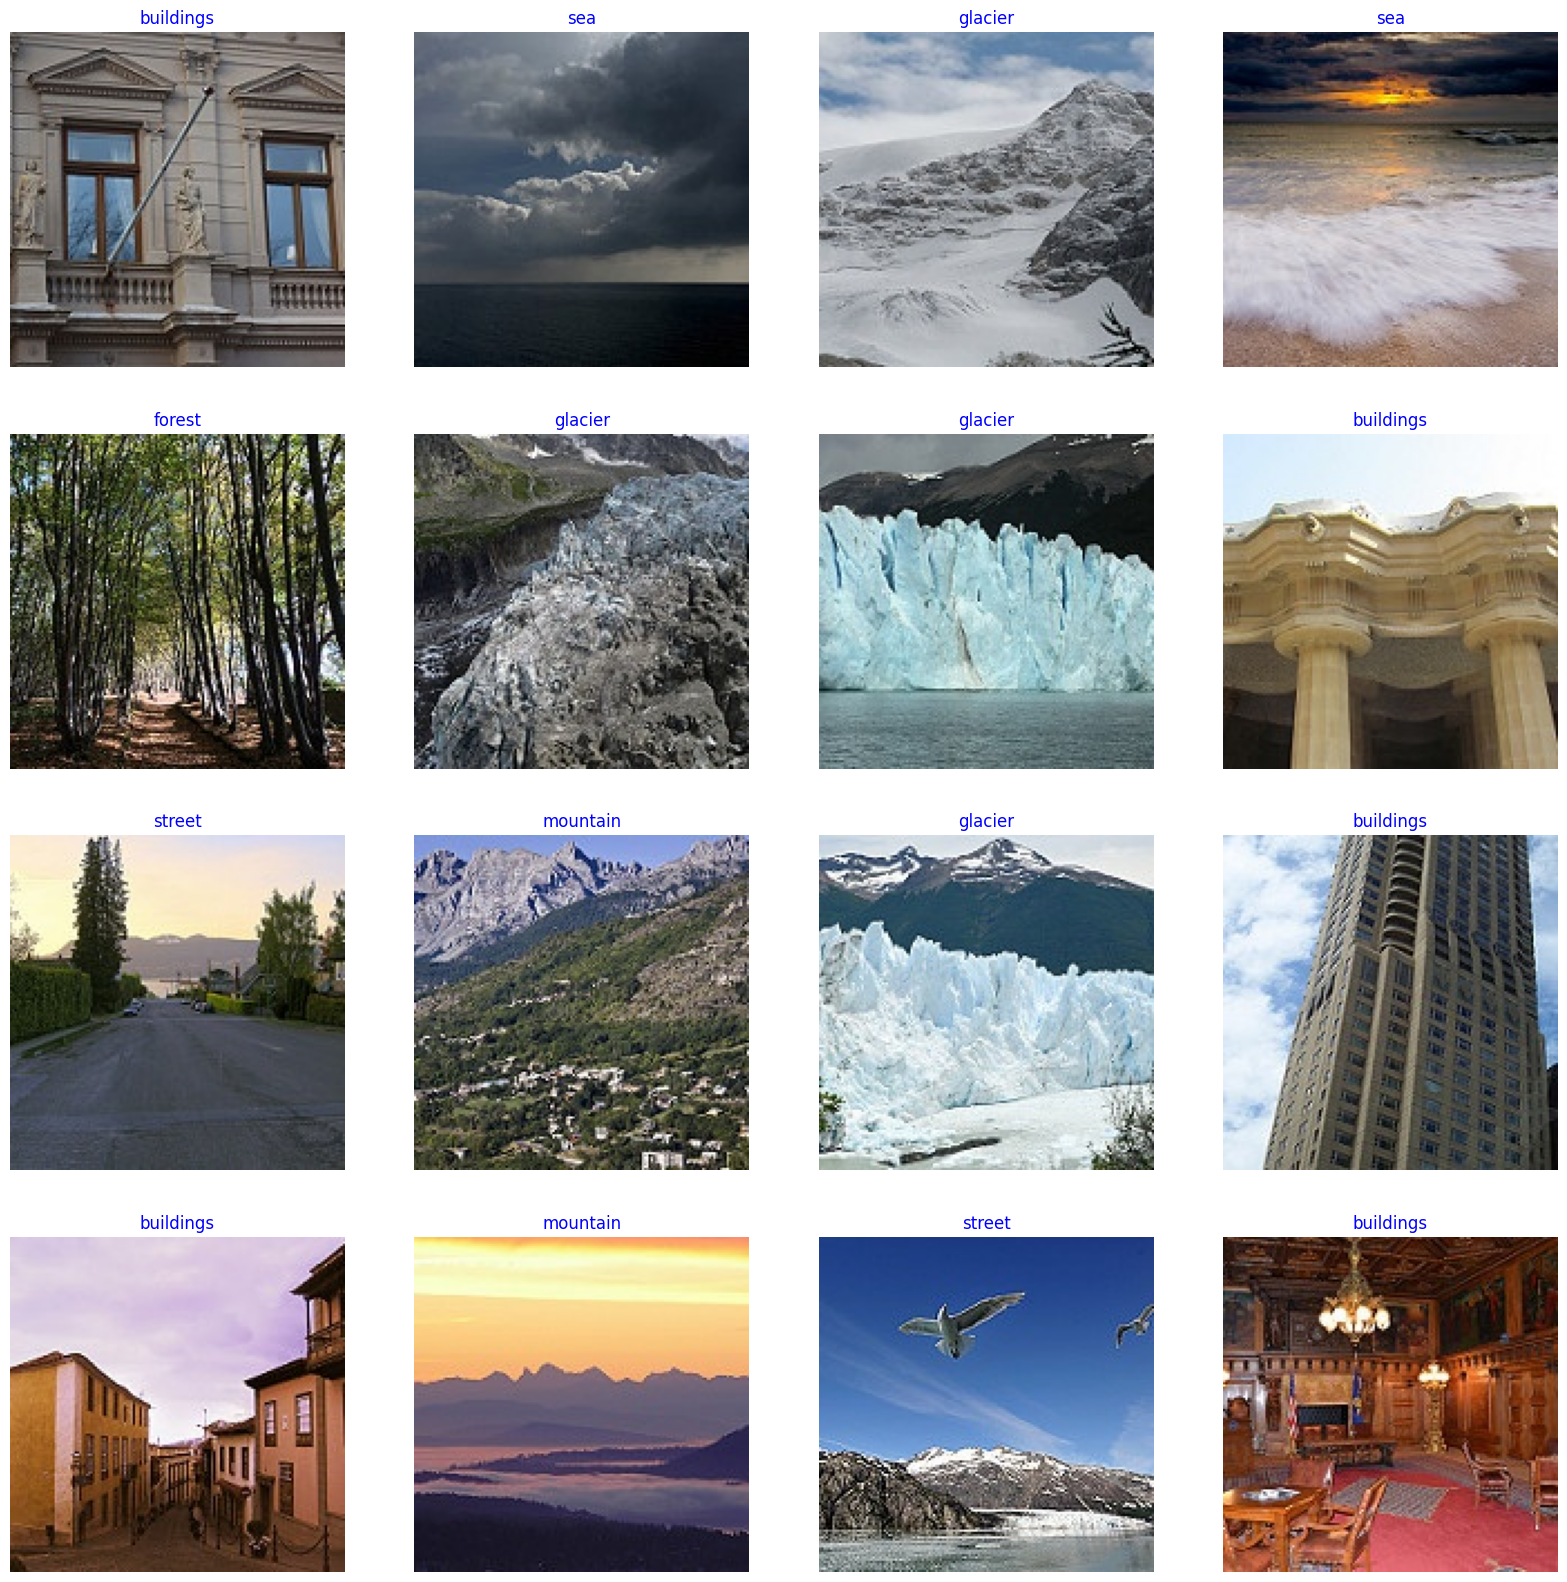

In [ ]:
dict_gen = train_gen.class_indices
classes = list(dict_gen.keys())
images , labels = next(train_gen)

plt.figure(figsize=(20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'blue' , fontsize= 12)
    plt.axis('off')
plt.show();

##Model Structure

In [27]:
img_shape = (img_size[0] , img_size[1] , 3)
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top= False , weights= 'imagenet' , input_shape= img_shape , pooling= 'max')

num_classes = len(classes)

model = Sequential([
    base_model,
    BatchNormalization(axis = -1 , momentum = 0.99 , epsilon = 0.001),
    Dense(256 , activation= 'relu'),
    Dense(256 , activation= 'relu'),
    Dense(num_classes , activation= 'softmax')
])
model.compile(Adamax(learning_rate= 0.001) , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 batch_normalization_1 (Bat  (None, 1280)              5120      
 chNormalization)                                                
                                                                 
 dense_3 (Dense)             (None, 256)               327936    
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dense_5 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 4449961 (16.98 MB)
Trainable params: 440

##Model Performance

In [28]:
epochs = 10

history = model.fit(train_gen , epochs =epochs , verbose = 1 ,validation_data= valid_gen,validation_steps=None , shuffle = False )

Epoch 1/10
533/533 [==============================] - 123s 161ms/step - loss: 0.9723 - accuracy: 0.7325 - val_loss: 0.3315 - val_accuracy: 0.9360
Epoch 2/10
533/533 [==============================] - 82s 154ms/step - loss: 0.7850 - accuracy: 0.7885 - val_loss: 0.3472 - val_accuracy: 0.9384
Epoch 3/10
533/533 [==============================] - 82s 154ms/step - loss: 0.6771 - accuracy: 0.8093 - val_loss: 0.2787 - val_accuracy: 0.9308
Epoch 4/10
533/533 [==============================] - 81s 153ms/step - loss: 0.5417 - accuracy: 0.8372 - val_loss: 0.3636 - val_accuracy: 0.8966
Epoch 5/10
533/533 [==============================] - 81s 152ms/step - loss: 0.3871 - accuracy: 0.8765 - val_loss: 0.6096 - val_accuracy: 0.8483
Epoch 6/10
533/533 [==============================] - 83s 155ms/step - loss: 0.2713 - accuracy: 0.9106 - val_loss: 0.7879 - val_accuracy: 0.8454
Epoch 7/10
533/533 [==============================] - 82s 153ms/step - loss: 0.1973 - accuracy: 0.9344 - val_loss: 1.0358 - val_a

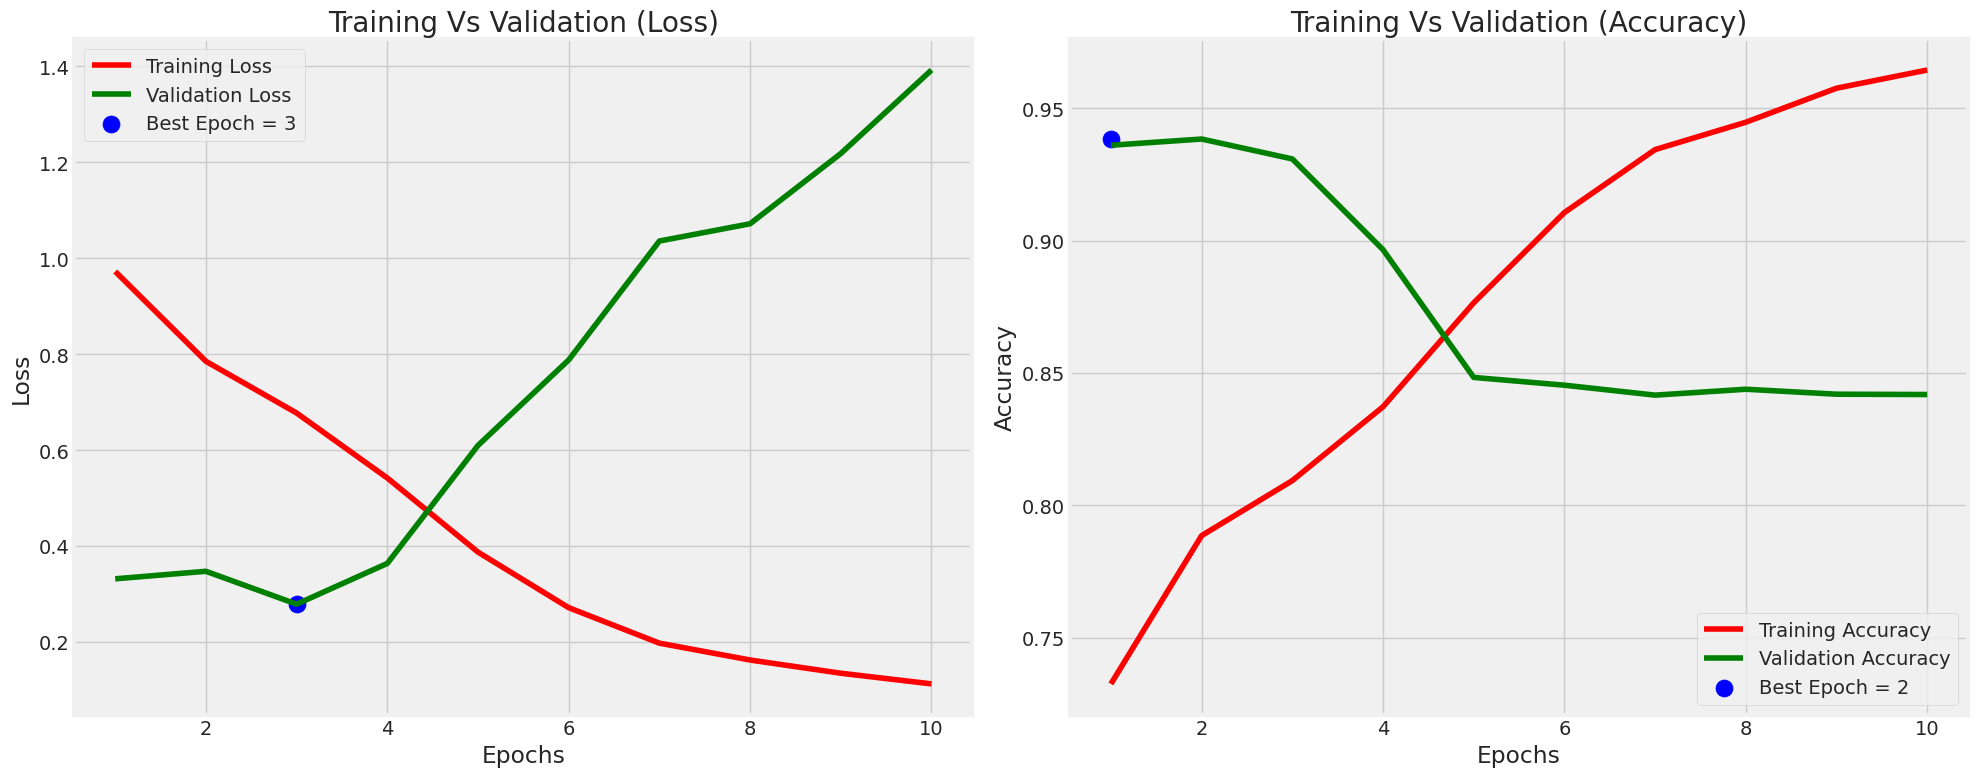

In [29]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
index_acc = np.argmax(val_acc)
val_lowest = val_loss[index_loss]
val_highest = val_acc[index_acc]

epochs = [i+1 for i in range(len(train_acc))]
loss_label = f'Best Epoch = {str(index_loss + 1)}'
acc_loss = f'Best Epoch = {str(index_acc +1)}'

#Training Accuracy
plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue' , label= loss_label)
plt.title('Training Vs Validation (Loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs , train_acc , 'r' , label= 'Training Accuracy')
plt.plot(epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc , val_highest , s= 150 , c= 'blue' , label = acc_loss)
plt.title('Training Vs Validation (Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show();

##Model Evaluation

In [30]:
train_score = model.evaluate(train_gen , steps = 32 , verbose = 1)
valid_score = model.evaluate(valid_gen , steps = 32 , verbose = 1)
test_score = model.evaluate(test_gen , steps = 32 , verbose = 1)
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

32/32 [==============================] - 1s 37ms/step - loss: 1.3060 - accuracy: 0.8525
Train Loss:  0.025740385055541992
Train Accuracy:  0.9931640625
--------------------
Validation Loss:  1.4252901077270508
Validation Accuracy:  0.833984375
--------------------
Test Loss:  1.306030035018921
Test Accuracy:  0.8525390625


##Model Prediction

##Confusion Matrix

In [31]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds , axis = 1)

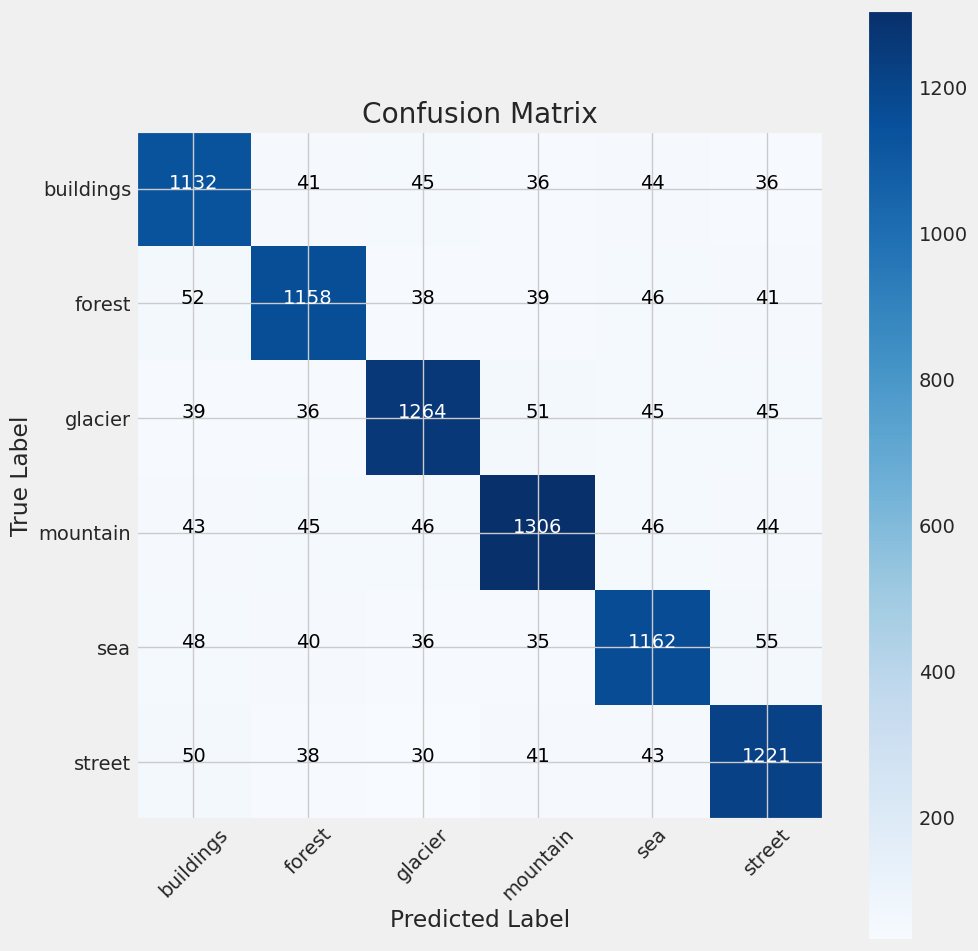

In [32]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

##Classification Report

In [33]:
print(classification_report(test_gen.classes, y_pred , target_names= classes ))

              precision    recall  f1-score   support

   buildings       0.83      0.85      0.84      1334
      forest       0.85      0.84      0.85      1374
     glacier       0.87      0.85      0.86      1480
    mountain       0.87      0.85      0.86      1530
         sea       0.84      0.84      0.84      1376
      street       0.85      0.86      0.85      1423

    accuracy                           0.85      8517
   macro avg       0.85      0.85      0.85      8517
weighted avg       0.85      0.85      0.85      8517



In [34]:
base_model = ResNet50(include_top= False , weights= 'imagenet' , input_shape= img_shape , pooling= 'max')

num_classes = len(classes)

model2 = Sequential([
    base_model,
    BatchNormalization(axis = -1 , momentum = 0.99 , epsilon = 0.001),
    Dense(256 , activation= 'relu'),
    Dense(256 , activation= 'relu'),
    Dense(num_classes , activation= 'softmax')
])
model2.compile(Adamax(learning_rate= 0.001) , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model2.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 batch_normalization_2 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dense_6 (Dense)             (None, 256)               524544    
                                                                 
 dense_7 (Dense)             (None, 256)               65792     
                                                                 
 dense_8 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 24187782 (92.27 MB)
Trainable params: 241

In [36]:
epochs = 10

history2 = model.fit(train_gen , epochs =epochs , verbose = 1 ,validation_data= valid_gen,validation_steps=None , shuffle = False )

Epoch 1/10
533/533 [==============================] - 81s 152ms/step - loss: 0.0964 - accuracy: 0.9692 - val_loss: 1.3898 - val_accuracy: 0.8436
Epoch 2/10
533/533 [==============================] - 81s 152ms/step - loss: 0.0925 - accuracy: 0.9698 - val_loss: 1.4196 - val_accuracy: 0.8428
Epoch 3/10
533/533 [==============================] - 82s 153ms/step - loss: 0.0829 - accuracy: 0.9733 - val_loss: 1.6041 - val_accuracy: 0.8411
Epoch 4/10
533/533 [==============================] - 82s 154ms/step - loss: 0.0734 - accuracy: 0.9770 - val_loss: 1.5929 - val_accuracy: 0.8433
Epoch 5/10
533/533 [==============================] - 82s 154ms/step - loss: 0.0747 - accuracy: 0.9759 - val_loss: 1.6232 - val_accuracy: 0.8434
Epoch 6/10
533/533 [==============================] - 82s 154ms/step - loss: 0.0681 - accuracy: 0.9782 - val_loss: 1.7530 - val_accuracy: 0.8420
Epoch 7/10
533/533 [==============================] - 82s 154ms/step - loss: 0.0671 - accuracy: 0.9785 - val_loss: 1.7759 - val_ac

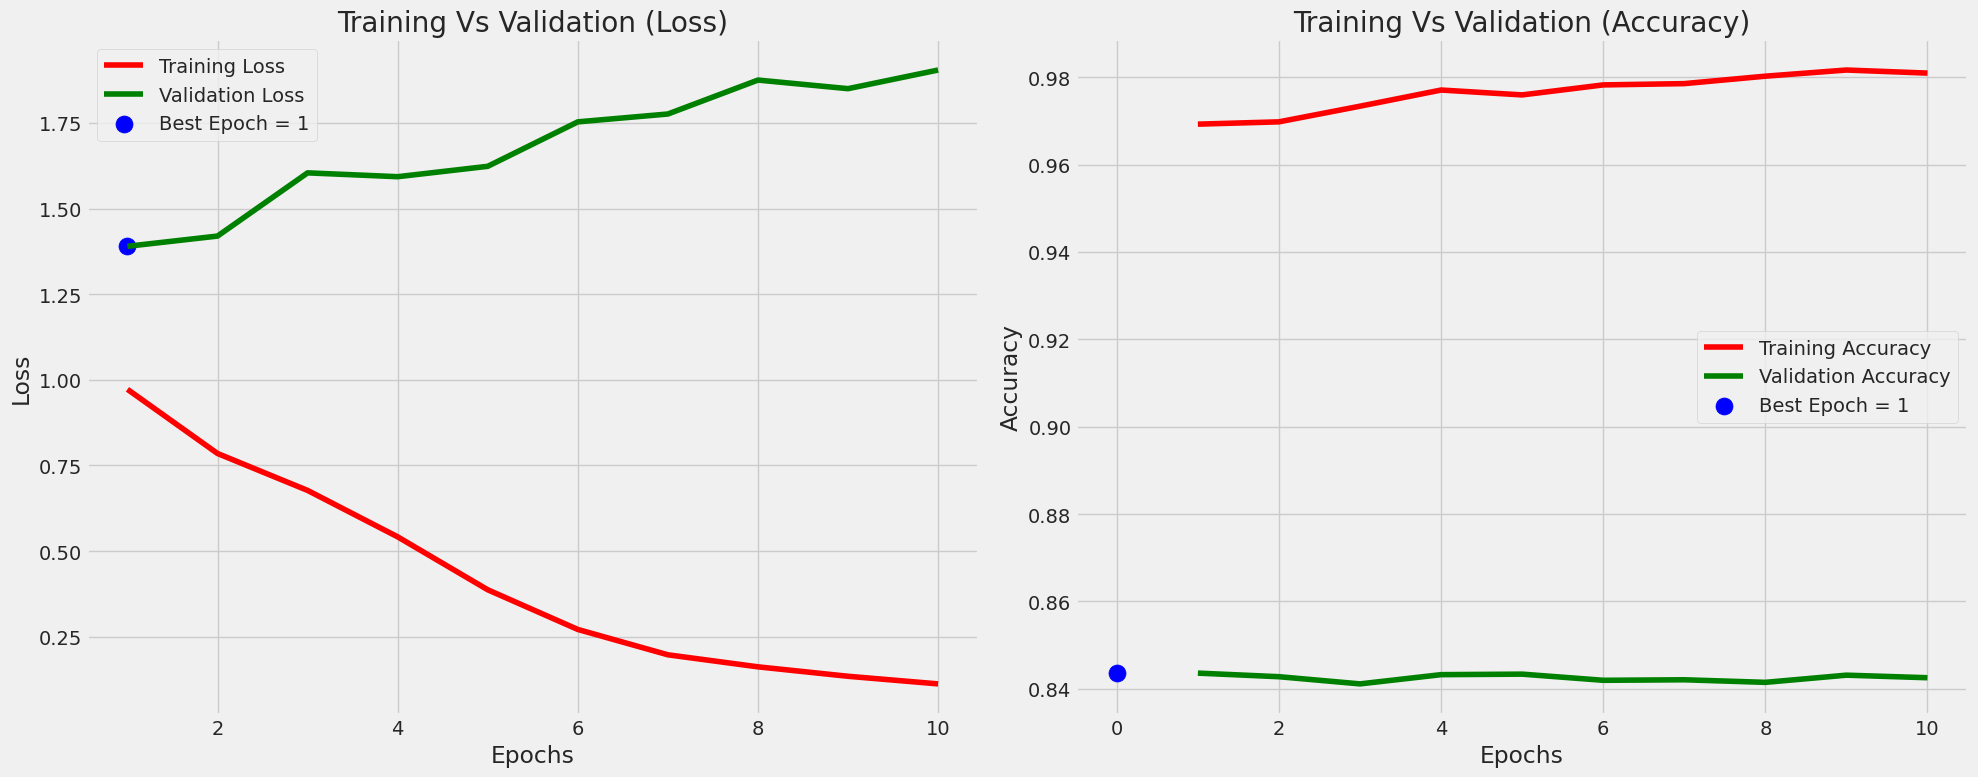

In [37]:
train_acc = history2.history['accuracy']
train_loss = history.history['loss']

val_acc = history2.history['val_accuracy']
val_loss = history2.history['val_loss']

index_loss = np.argmin(val_loss)
index_acc = np.argmax(val_acc)
val_lowest = val_loss[index_loss]
val_highest = val_acc[index_acc]

epochs = [i+1 for i in range(len(train_acc))]
loss_label = f'Best Epoch = {str(index_loss + 1)}'
acc_loss = f'Best Epoch = {str(index_acc +1)}'

#Training Accuracy
plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue' , label= loss_label)
plt.title('Training Vs Validation (Loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs , train_acc , 'r' , label= 'Training Accuracy')
plt.plot(epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc , val_highest , s= 150 , c= 'blue' , label = acc_loss)
plt.title('Training Vs Validation (Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show();

## Model(s) for the flipped images

In [38]:
img_shape = (img_size[0] , img_size[1] , 3)
base_model1 = tf.keras.applications.efficientnet.EfficientNetB0(include_top= False , weights= 'imagenet' , input_shape= img_shape , pooling= 'max')

num_classes = len(classes)

model1 = Sequential([
    base_model1,
    BatchNormalization(axis = -1 , momentum = 0.99 , epsilon = 0.001),
    Dense(256 , activation= 'relu'),
    Dense(256 , activation= 'relu'),
    Dense(num_classes , activation= 'softmax')
])
model1.compile(Adamax(learning_rate= 0.001) , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

In [40]:
epochs = 10

history1 = model1.fit(x = train_gen , epochs =epochs , verbose = 1 ,validation_data= valid_gen,validation_steps=None , shuffle = False)

Epoch 1/10
533/533 [==============================] - 113s 156ms/step - loss: 0.9747 - accuracy: 0.7299 - val_loss: 0.3346 - val_accuracy: 0.9317
Epoch 2/10
533/533 [==============================] - 82s 154ms/step - loss: 0.7708 - accuracy: 0.7890 - val_loss: 0.3418 - val_accuracy: 0.9360
Epoch 3/10
533/533 [==============================] - 83s 156ms/step - loss: 0.6611 - accuracy: 0.8137 - val_loss: 0.2821 - val_accuracy: 0.9266
Epoch 4/10
533/533 [==============================] - 82s 153ms/step - loss: 0.5166 - accuracy: 0.8413 - val_loss: 0.4239 - val_accuracy: 0.8786
Epoch 5/10
533/533 [==============================] - 83s 156ms/step - loss: 0.3717 - accuracy: 0.8777 - val_loss: 0.5959 - val_accuracy: 0.8526
Epoch 6/10
533/533 [==============================] - 83s 156ms/step - loss: 0.2504 - accuracy: 0.9164 - val_loss: 0.8078 - val_accuracy: 0.8483
Epoch 7/10
533/533 [==============================] - 83s 156ms/step - loss: 0.1836 - accuracy: 0.9386 - val_loss: 0.9815 - val_a

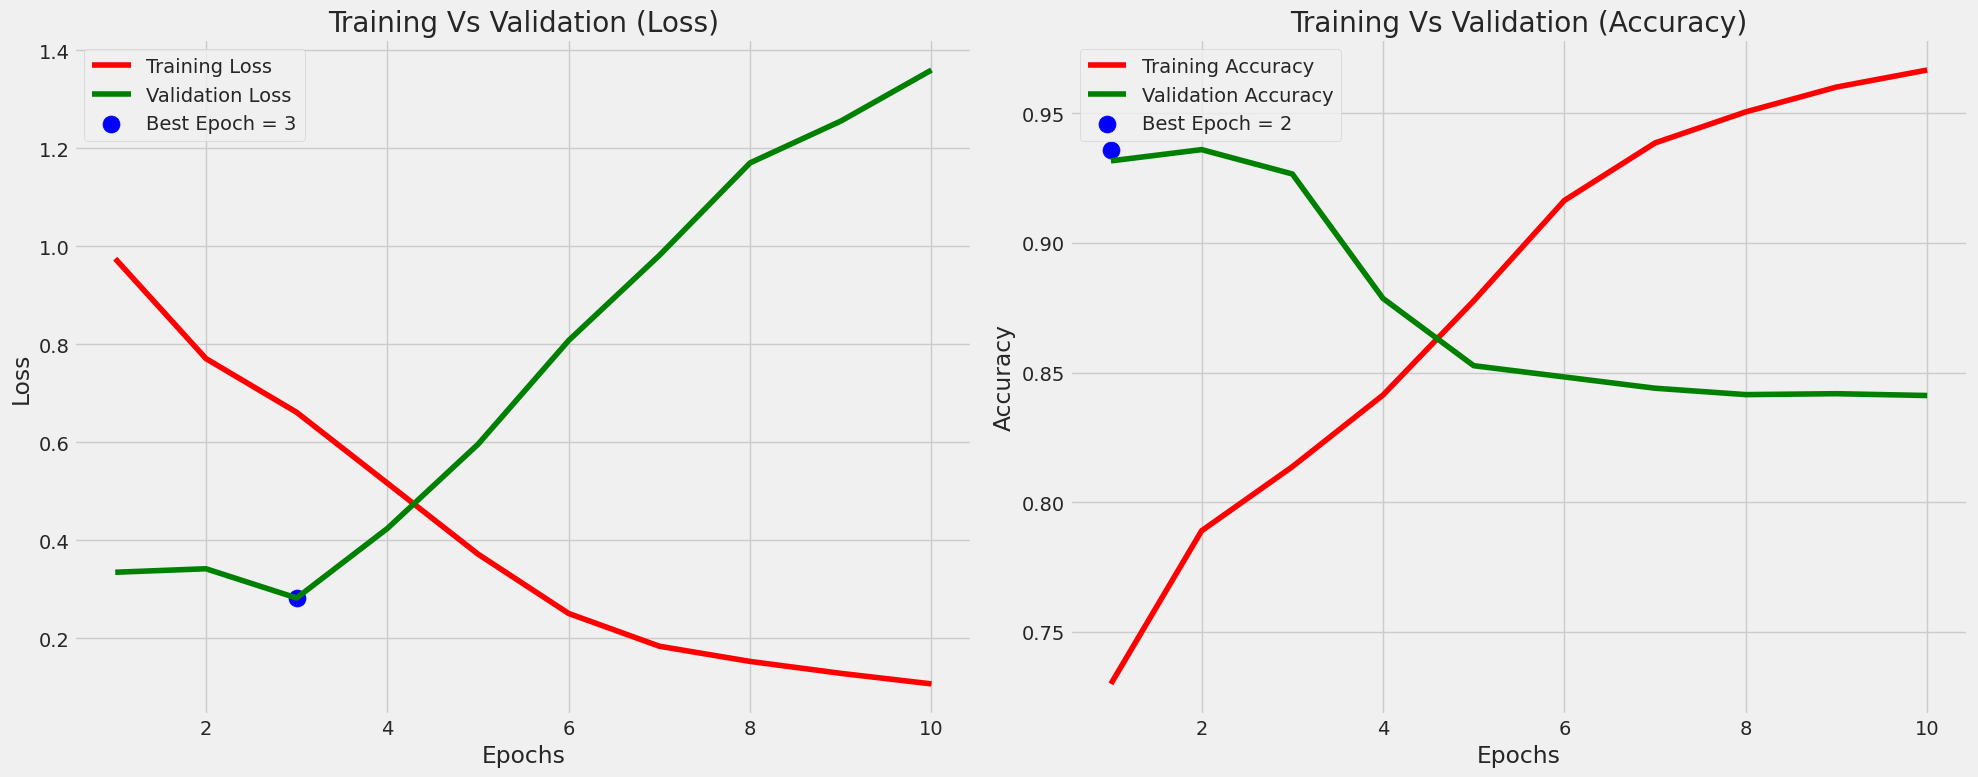

In [41]:
train_acc = history1.history['accuracy']
train_loss = history1.history['loss']

val_acc = history1.history['val_accuracy']
val_loss = history1.history['val_loss']

index_loss = np.argmin(val_loss)
index_acc = np.argmax(val_acc)
val_lowest = val_loss[index_loss]
val_highest = val_acc[index_acc]

epochs = [i+1 for i in range(len(train_acc))]
loss_label = f'Best Epoch = {str(index_loss + 1)}'
acc_loss = f'Best Epoch = {str(index_acc +1)}'

#Training Accuracy
plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue' , label= loss_label)
plt.title('Training Vs Validation (Loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs , train_acc , 'r' , label= 'Training Accuracy')
plt.plot(epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc , val_highest , s= 150 , c= 'blue' , label = acc_loss)
plt.title('Training Vs Validation (Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show();